In [215]:
import numpy as np
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az

# Regression with interval data

Interval regression is used to model outcomes that have interval censoring, that is we only know that the output belongs to a certain interval. This type of data is very common in surveys: for instance we 
may know that the outcome of a person is in the interval $[50000, 70000]$ Euro. Another example is quality. Assessing the precise quality of a product (for instance the output of a manufacturing process) can be very costly (in terms of time and money). However, it is usually quite fast for a human expert to provide a range for the quality of a product (quality is between 2 and 5).

In this notebook, we will use a dataset from manufacturing that provides  interval quality data of a product based on the manufacturing temperature.

Our goal is to answer the following question: Can we guarantee that the quality of a product manufactured a 320 degree is at least $7.2$? Let's assume that this is important to satisfy a requirement from a customer.


In [197]:
df=pd.read_csv("../datasets/manufacturing_quality_interval.csv",delimiter=",")
df.iloc[:,1:].head(5)


,temperature,Quality_lower,Quality_upper
0,184.0,2.0,4.0
1,244.0,5.0,7.0
2,100.0,1.0,3.0
3,160.0,2.0,5.0
4,130.0,1.0,4.0


The quality of the first product (manufactured a 184 degree) is between 2 and 4.

Text(0, 0.5, 'quality')

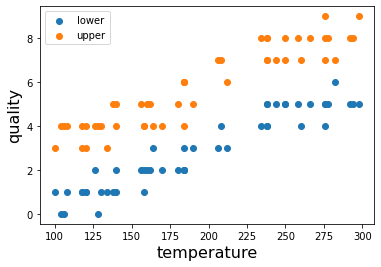

In [211]:
#Plot the data
temperature=df['temperature'].values
yl=df['Quality_lower'].values
yu=df['Quality_upper'].values

plt.scatter(temperature,yl, color='C0' ,label='lower')
plt.scatter(temperature,yu, color='C1'  ,label='upper')
plt.legend()
plt.xlabel("temperature",fontsize=16)
plt.ylabel("quality",fontsize=16)

A common approach to deal with interval data is to consider the mid-point and use standard regression to solve our prediction problem

In [213]:
y = (yl+yu)/2#mid point

In [214]:
regmodel=pm.Model()
with regmodel:
    alpha = pm.Normal('alpha',0.0,30)
    beta  = pm.Normal('beta',0.0,30)
    sigma = pm.Uniform('sigma',0.0001,30)
    mu = beta*temperature+alpha
    pm.Normal('Like',mu,sigma,observed=y)

with regmodel:
    posterior_samples_mid=pm.sample(5000,tune=1000,chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 0, 0 divergences: 100%|██████████| 6000/6000 [00:09<00:00, 641.85it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Text(0, 0.5, 'quality')

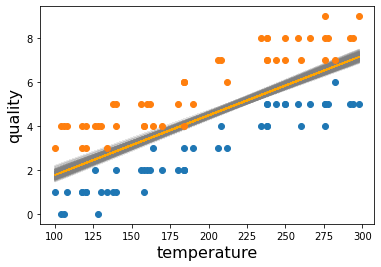

In [201]:
xx=temperature
for i in range(200):
    plt.plot(xx,xx*posterior_samples_mid['beta'][i]+posterior_samples_mid['alpha'][i],c='gray',alpha=0.2)#regression line
plt.plot(xx,xx*posterior_samples_mid['beta'].mean()+posterior_samples_mid['alpha'].mean(),c='orange')
#ypred=np.mean(posterior_samples['alpha']) + np.dot(np.mean(posterior_samples['beta']), temperature)
#plt.plot(temperature,ypred)
plt.scatter(temperature,yl, color='C0' ,Zorder=1000)
plt.scatter(temperature,yu, color='C1'  ,Zorder=1000)
plt.xlabel("temperature",fontsize=16)
plt.ylabel("quality",fontsize=16)

Our prediction a 320 degree can be computed as follows

Text(0, 0.5, 'quality')

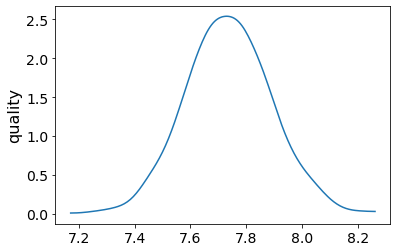

In [217]:
#density plot
az.plot_dist(320*posterior_samples_mid['beta']+posterior_samples_mid['alpha'])
plt.xlabel("quality",fontsize=16)

The density plot tells us that, even considering the uncertainty, we are "almost certainly" sure that the quality will be greater than 7.2.

We compute the probability that quality is greater than 7.2 as follows.

In [252]:
Prob = len(np.where(320*posterior_samples_mid['beta']+posterior_samples_mid['alpha']>7.2)[0])/len(posterior_samples_mid['beta'])
print("Probability that quality is greater than 7.2=",Prob)

Probability that quality is greater than 7.2= 0.9996


We will see that this is over-optimistic. 
`Sklearn` does not provide us such information either, it only returns a point prediction

In [240]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(temperature.reshape(-1,1), y)
print("prediction=", reg.predict(np.array([[320]])))

prediction= [7.74103371]


### Correct modelling
Interval data are both left and right censored, so we can extend the model we have used for censoring to correctly make predictions based on interval data.

Let's  denote quality with $y$, then the probability that quality is for instance less than 5  is
$$
p(y\leq 5)= \int_{-\infty}^{5} N(y_{nc},\mu,\sigma) d y_{nc}=\Phi((5-\mu)/\sigma,0,1)
$$
and 
the probability that quality is greater than 2 is

$$
p(y\geq 2)= \int_{2}^{\infty} N(y,\mu,\sigma) d y_{nc}=1-\Phi((2-\mu)/\sigma,0,1)=\Phi(-(2-\mu)/\sigma,0,1)
$$

and  the probability that quality is less than 5 and greater than 2 can be approximatively written as

$$
p(2 \leq y\leq 5)= \Phi((5-\mu)/\sigma,0,1)\Phi(-(2-\mu)/\sigma,0,1)
$$

To write the above results we have exploited properties of the Gaussian CDF (see last section at the end of the notebook).

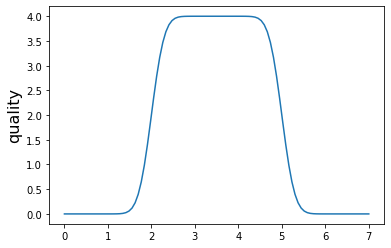

In [231]:
mu=np.linspace(0,7,100)
sigma=1/3
plt.plot(mu,tt.erfc(-(5-mu)/sigma).eval()*tt.erfc((2-mu)/sigma).eval())
plt.ylabel("quality",fontsize=16);

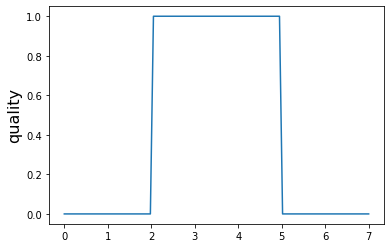

In [233]:
sigma=1/300
plt.plot(mu,0.25*tt.erfc(-(5-mu)/sigma/np.sqrt(2)).eval()*tt.erfc((2-mu)/sigma/np.sqrt(2)).eval())
plt.ylabel("quality",fontsize=16);

Note that by increasing the value of $\sigma$ we assign non zero probability to values lower than 2 and, respectively, greater than 5. This allows us to account for the possibility than the range observation returned by the human expert may be wrong (she/he may have said 2 and 5, but the quality is 6).
We do not know sigma, but we can learn it from data using the following probabilistic model:

1. interval data $[y^l_i,y^u_i]$
2. the input is the temperature $t_i$.

You goal is to implement a Bayesian linear regression model with interval type outputs.

**Likelihood**

$$
p(y^l_i,y^u_i|\alpha,\beta,\sigma,t_i)=\Phi((y^u_i-\mu_i)/\sigma,0,1)\Phi(-(y^l_i-\mu_i)/\sigma,0,1)
$$
with $\mu_i=\alpha+\beta t_i$.

Therefore, assuming the observations are independent

$$
p(Data|\alpha,\beta,\sigma)=\prod_{i=1}^{n}\Phi((y^u_i-\mu_i)/\sigma,0,1)\Phi(-(y^l_i-\mu_i)/\sigma,0,1)
$$
where $n$ is the number of measurements.

**Prior**
$$
p(\alpha)=N(\alpha,0,30), ~~p(\beta)=N(\beta,0,30), ~~p(\sigma)=\text{Uniform}(\sigma,0.0001,30)
$$

**Posterior** 
You have to use PyMC3 to sample from the posterior define by the above model, that is

$$
\underbrace{p(\alpha,\beta,\sigma|\text{data})}_{\text{posterior}} = \frac{\underbrace{\prod_{i=1}^{n}\Phi((y^u_i-\mu_i)/\sigma,0,1)\Phi(-(y^l_i-\mu_i)/\sigma,0,1)}_{\text{likelihood}}\underbrace{N(\alpha,0,30)N(\beta,0,30)\text{Uniform}(\sigma,0.001,30)}_{\text{prior}}}{\underbrace{p(\text{data})}_{\text{evidence}}}
$$

Hereafter the PyMC3 code that implements the above model.

In [263]:
import theano.tensor as tt

def custom_dist_logp(mu,sigma,yl,yu):
    return pm.Bernoulli.dist(0.5*tt.erfc(-(yu-mu)/sigma/np.sqrt(2))).logp(1.0)+pm.Bernoulli.dist(0.5*tt.erfc((yl-mu)/sigma/np.sqrt(2))).logp(1.0)


mymodel=pm.Model()
with mymodel:
    alpha = pm.Normal('alpha',0.0,30)
    beta  = pm.Normal('beta', 0.0,30)
    sigma = pm.Uniform('sigma',0.0001,30)
    mu=alpha+beta*temperature
    l1=pm.DensityDist('Like',custom_dist_logp,observed=dict(mu=mu, sigma=sigma, yl=yl, yu=yu))

with mymodel:
    posterior_samples=pm.sample(5000,tune=2000,chains=1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 0, 1,056 divergences: 100%|██████████| 7000/7000 [00:13<00:00, 518.38it/s]
There were 1057 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


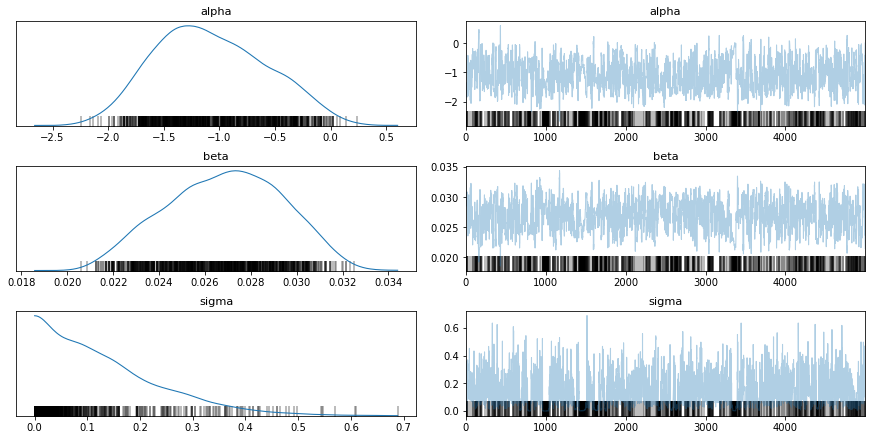

In [264]:
pm.traceplot(posterior_samples);

Text(0, 0.5, 'quality')

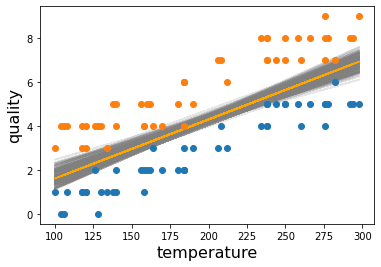

In [265]:
xx=temperature
for i in range(200):
    plt.plot(xx,xx*posterior_samples['beta'][i]+posterior_samples['alpha'][i],c='gray',alpha=0.2)#regression line
plt.plot(xx,xx*posterior_samples['beta'].mean()+posterior_samples['alpha'].mean(),c='orange')

plt.scatter(temperature,yl, color='C0' ,Zorder=1000)
plt.scatter(temperature,yu, color='C1'  ,Zorder=1000)
plt.xlabel("temperature",fontsize=16)
plt.ylabel("quality",fontsize=16)

This is the prediction for the interval data model at 320 degree

Probability that quality is greater than 7.2= 0.7972


Text(0, 0.5, 'quality')

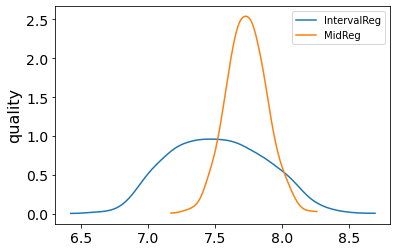

In [254]:
az.plot_dist(320*posterior_samples['beta']+posterior_samples['alpha'],label='IntervalReg')
az.plot_dist(320*posterior_samples_mid['beta']+posterior_samples_mid['alpha'],label='MidReg')

Prob = len(np.where(320*posterior_samples['beta']+posterior_samples['alpha']>7.2)[0])/len(posterior_samples['beta'])
print("Probability that quality is greater than 7.2=",Prob)
plt.ylabel("quality",fontsize=16)

Note that, by correctly modelling interval data, we can say that the probability that quality will be greater than $7.2$ is only 80%, which is not anymore "almost certainty".

We can see how by using probabilistic machine learning we can answer  the initial question properly. 

### Alternative way to write the PyMC3
There is an alternative (but equivalent) way to write the previous PyMC3 model, that is by splitting the lower and upper measurements

In [261]:
import theano.tensor as tt

def custom_dist_lower_logp(mu,sigma,yl):
    return pm.Bernoulli.dist(0.5*tt.erfc((yl-mu)/sigma/np.sqrt(2))).logp(1.0)

def custom_dist_upper_logp(mu,sigma,yu):
    return pm.Bernoulli.dist(0.5*tt.erfc(-(yu-mu)/sigma/np.sqrt(2))).logp(1.0)


mymodel=pm.Model()
with mymodel:
    alpha = pm.Normal('alpha',0.0,30)
    beta  = pm.Normal('beta', 0.0,30)
    sigma = pm.Uniform('sigma',0.0001,30)
    mu=alpha+beta*temperature
    l1=pm.DensityDist('Like1',custom_dist_lower_logp,observed=dict(mu=mu, sigma=sigma, yl=yl))
    l2=pm.DensityDist('Like2',custom_dist_upper_logp,observed=dict(mu=mu, sigma=sigma, yu=yu))

with mymodel:
    posterior_samples=pm.sample(5000,tune=2000,chains=1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 0, 838 divergences: 100%|██████████| 7000/7000 [00:15<00:00, 450.45it/s]
There were 838 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


PyMC3 multiplies the all the distributions inside `with model` (n log scale it sums them) and so this and the previous model are equivalent.

Text(0, 0.5, 'quality')

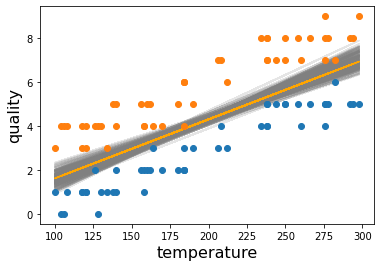

In [262]:
xx=temperature
for i in range(200):
    plt.plot(xx,xx*posterior_samples['beta'][i]+posterior_samples['alpha'][i],c='gray',alpha=0.2)#regression line
plt.plot(xx,xx*posterior_samples['beta'].mean()+posterior_samples['alpha'].mean(),c='orange')


plt.scatter(temperature,yl, color='C0' ,Zorder=1000)
plt.scatter(temperature,yu, color='C1'  ,Zorder=1000)
plt.xlabel("temperature",fontsize=16)
plt.ylabel("quality",fontsize=16)

### Property of the gaussian CDF
In this notebook we have used the following properties of the gaussian Cumulative distribution Function:

$$
\Phi(z,\mu,\sigma)=\Phi((z-\mu)/\sigma,0,1)
$$

and


$$
1-\Phi((z-\mu)/\sigma,0,1)=\Phi(-(z-\mu)/\sigma,0,1)
$$

Also, we can write the CDF using the `erfc` function:

$$
\Phi(-(z-\mu)/\sigma,0,1)=0.5\,\text{erfc}\left(-\frac{z-\mu}{\sqrt{2}\sigma}\right)
$$

You can verify it numerically using the following code. 

In [247]:
import scipy.stats as st
from scipy.special import erfc
mu=2
sigma=3
z=5
print(st.norm(2,3).cdf(5),st.norm(0,1).cdf((5-2)/3))
print(1-st.norm(0,1).cdf((5-2)/3),st.norm(0,1).cdf(-(5-2)/3))
print(st.norm(0,1).cdf((5-2)/3),0.5*erfc(-(5-2)/3/np.sqrt(2)))

0.8413447460685429 0.8413447460685429
0.15865525393145707 0.15865525393145707
0.8413447460685429 0.8413447460685429
